In [38]:
# 3-1 임포트
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import extra_keras_datasets.emnist as emnist
import cv2
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout

In [56]:
# 3-2 사진 가져오기
img_letter = cv2.imread('C:\\Users\\user\\MyPython\\img\\c_test.png')

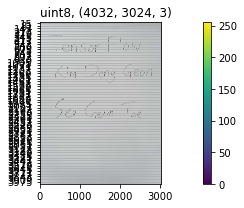

In [40]:
# 3-3
def compatible_image(img):
    if img.ndim == 3 and img.shape[2] == 1:
        img = img.reshape(img.shape[0], img.shape[1])
    return img

def show_image(img, y_offset=0, y_steps=None, colorbar=True):
    plt.rcParams["font.size"] = 10
    plt.figure(figsize=(12, 3))
    plt.imshow(compatible_image(img))
    plt.title("{}, {}".format(img.dtype, img.shape), fontsize=12, loc="left")
    
    if y_steps:
        plt.yticks(np.arange(y_offset, img.shape[0] + 1, y_steps))
        plt.grid(True, axis="y")
        
    if colorbar:
        plt.colorbar()
    plt.tight_layout()
    plt.show()
    
show_image(img_letter, y_offset=15, y_steps=66)

In [69]:
# 3-4 컬러로 이미지를 읽어온다
img_letter = cv2.imread('C:\\Users\\user\\MyPython\\img\\c_test.png', cv2.IMREAD_COLOR)

# 3-5 흑백으로 이미지를 변환한다
img_letter_gray = cv2.cvtColor(img_letter, cv2.COLOR_BGR2GRAY)

# 3-6 cv2.MSER_create() 클래스를 선언한다.
mser = cv2.MSER_create()

# 3-7 mser.detectRegions(흑백이미지) => 오브젝트 위치를 구한다
reg, _ = mser.detectRegions(img_letter_gray)

# 3-8 해당 이미지의 오브젝트 위치에 바운드 박스를 그린다
img_copy = img_letter.copy()

for r in reg:
    (x , y, w, h) = cv2.boundingRect(np.reshape(r,(-1,1,2)))
    cv2.rectangle(img_copy, (x, y), (x+w, y+h), (0,0,255),1)
    
print(img_copy)

# cv2.imshow('mser', img_copy)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

[[[192 197 196]
  [192 197 196]
  [192 197 196]
  ...
  [174 174 174]
  [174 174 174]
  [174 174 174]]

 [[192 197 196]
  [192 197 196]
  [192 197 196]
  ...
  [174 174 174]
  [174 174 174]
  [174 174 174]]

 [[192 197 196]
  [192 197 196]
  [192 197 196]
  ...
  [174 174 174]
  [174 174 174]
  [174 174 174]]

 ...

 [[212 219 222]
  [211 218 221]
  [209 216 219]
  ...
  [189 196 199]
  [189 196 199]
  [189 196 199]]

 [[214 221 224]
  [213 220 223]
  [211 218 221]
  ...
  [189 196 199]
  [189 196 199]
  [189 196 199]]

 [[215 222 225]
  [214 221 224]
  [213 220 223]
  ...
  [189 196 199]
  [189 196 199]
  [189 196 199]]]


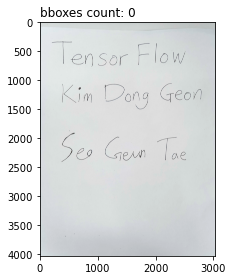

In [70]:
def merge_bboxes(bboxes, threshold, min_size=2, max_size=64):
    targets = filter(       
        lambda x: min_size <= x[2] <= max_size and min_size <= x[3] <= max_size,
        bboxes,
    )    
    results = []
    for bbox in targets:
        like_bbox = list(
            filter(
                lambda x: x[0] - threshold <= bbox[0] <= x[0] + threshold
                and x[1] - threshold <= bbox[1] <= x[1] + threshold
                and x[2] - threshold <= bbox[2] <= x[2] + threshold
                and x[3] - threshold <= bbox[3] <= x[3] + threshold,
                results,
            )
        )       
        if like_bbox == []:
            results.append(bbox)
    return results

def detect_bboxes(img, y_offset, y_steps, delta=40, min_area=80, max_area=400):
    mser = cv2.MSER_create()
    mser.setDelta(delta)
    mser.setMinArea(min_area)
    mser.setMaxArea(max_area)
    mser.setPass2Only(True)  
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    msers, bboxes = mser.detectRegions(gray)
    unique_bboxes = merge_bboxes(bboxes, threshold=16)  
    img_width = gray.shape[1]
    unique_bboxes.sort(
        key=lambda b: int((b[1] - y_offset) / y_steps) * img_width + b[0]
    )
    return unique_bboxes

bboxes = detect_bboxes(img_letter, y_offset=15, y_steps=66)

def show_bboxes(img, bboxes, alpha=0.25):  
    vis, overlay = img.copy(), img.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i, bbox in enumerate(bboxes):
        x, y, w, h = bbox
        cv2.rectangle(overlay, (x, y), (x + w, y + h), (0xFF, 0x00, 0), thickness=-1)
        cv2.putText(vis, str(i), (x, y - 4), font, 0.42, (0, 0, 0xFF), 1, cv2.LINE_AA)
    vis = cv2.addWeighted(overlay, alpha + 0.1, vis, 1 - alpha, 0)
    plt.rcParams["font.size"] = 10
    plt.figure(figsize=(11, 4))
    plt.imshow(compatible_image(vis))
    plt.title("bboxes count: {}".format(len(bboxes)), fontsize=12, loc="left")
    plt.tight_layout()
    plt.show()
    
show_bboxes(img_letter, bboxes)

def crop_image(img, bbox, target_size, padding, expand=1):
    x, y, w, h = bbox
    crop = tf.image.crop_to_bounding_box(
        img, y - expand, x - expand, h + (expand * 2), w + (expand * 2)
    )    
    iw, ih, _ = crop.shape
    edge_len = tf.reduce_max([iw, ih]) + (padding * 2)  
    crop = tf.image.resize_with_crop_or_pad(crop, edge_len, edge_len)
    method = tf.image.ResizeMethod.MITCHELLCUBIC
    crop = tf.image.resize(crop, [target_size, target_size], method=method)
    return crop

def setup_data(img, bboxes, target_size=28, padding=2):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    gray = gray.astype("float32")
    gray = gray / 255.0
    gray = np.expand_dims(gray, 2) 
    crop_images = []
    for i, bbox in enumerate(bboxes):
        crop_images.append(crop_image(gray, bbox, target_size, padding))    
    return np.array(crop_images)

crop_images = setup_data(img_letter, bboxes)

In [35]:
model = keras.models.load_model('my-model.h5')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 20, 20, 32)        25632     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 6, 6, 64)         